In [68]:
library(ggplot2)
library(tidyverse)
library(MASS)
library(janitor)
library(dplyr)
library(pROC)
library(irr)
library(reshape2)

In [69]:
train_data = read.csv("../data/train_data.csv")
test_data = read.csv("../data/test_data.csv")

In [70]:
glimpse(train_data)

Rows: 202,944
Columns: 21
$ diabetes_012           <int> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,~
$ high_bp                <int> 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,~
$ high_chol              <int> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,~
$ chol_check             <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ smoker                 <int> 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,~
$ stroke                 <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <int> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,~
$ phys_activity          <int> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,~
$ fruits                 <int> 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,~
$ veggies                <int> 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,~
$ hvy_alcohol_consump    <int> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,~
$ no_docbc_cos

## Data Preprocessing

In [72]:
train_data <- train_data |> mutate(across(everything(), as.factor))
test_data <- test_data |> mutate(across(everything(), as.factor))

In [73]:
glimpse(train_data)

Rows: 202,944
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,~
$ high_bp                <fct> 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,~
$ high_chol              <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,~
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ smoker                 <fct> 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,~
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,~
$ phys_activity          <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,~
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,~
$ veggies                <fct> 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,~
$ hvy_alcohol_consump    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,~
$ no_docbc_cos

In [81]:
print(table(train_data$diabetes_012))
print(table(test_data$diabetes_012))


     0      1      2 
170989   3676  28279 

    0     1     2 
42714   955  7067 


## Modeling

Hàm Cross Validation với K Folds = 5 cho LDA và QDA

In [82]:
# Cross validation LDA
# Cross validation LDA
lda_cross_validate <- function(model_formula, data, k = 5) {
    set.seed(123) # Set seed for reproducibility
    
    # Create k-folds
    folds <- sample(rep(1:k, length.out = nrow(data)))
    
    # Initialize a list to store results and models
    results <- list()
    models <- list()
    
    # Perform cross-validation
    for (i in 1:k) {
        # Split data into training and testing sets
        train_data <- data[folds != i, ]
        test_data <- data[folds == i, ]
        
        # Train the model on the training set
        model <- lda(formula = model_formula, data = train_data)
        
        # Predict on the testing set
        predictions <- predict(model, test_data)$class
        
        # Calculate metrics
        confusion <- table(predictions, test_data$diabetes_012)
        accuracy <- sum(diag(confusion)) / sum(confusion)
        precision <- diag(confusion) / rowSums(confusion)
        precision[is.nan(precision)] <- 0
        recall <- diag(confusion) / colSums(confusion)
        recall[is.nan(recall)] <- 0
        f1 <- 2 * (precision * recall) / (precision + recall)
        f1[is.nan(f1)] <- 0
        
        # Convert confusion matrix to data frame for kappam.fleiss
        confusion_df <- as.data.frame(as.table(confusion))
        kappa <- kappam.fleiss(confusion_df)$value
        
        # Store the result and model
        results[[i]] <- list(
            accuracy = accuracy,
            precision = precision,
            recall = recall,
            f1 = f1,
            kappa = kappa
        )
        models[[i]] <- model
    }
    
    return(list(models = models, results = results))
}

# Cross validation QDA
qda_cross_validate <- function(model_formula, data, k = 5) {
    set.seed(123) # Set seed for reproducibility
    
    # Create k-folds
    folds <- sample(rep(1:k, length.out = nrow(data)))
    
    # Initialize a list to store results and models
    results <- list()
    models <- list()
    
    # Perform cross-validation
    for (i in 1:k) {
        # Split data into training and testing sets
        train_data <- data[folds != i, ]
        test_data <- data[folds == i, ]
        
        # Train the model on the training set
        model <- qda(formula = model_formula, data = train_data)
        
        # Predict on the testing set
        predictions <- predict(model, test_data)$class
        
        # Calculate metrics
        confusion <- table(predictions, test_data$diabetes_012)
        accuracy <- sum(diag(confusion)) / sum(confusion)
        precision <- diag(confusion) / rowSums(confusion)
        precision[is.nan(precision)] <- 0
        recall <- diag(confusion) / colSums(confusion)
        recall[is.nan(recall)] <- 0
        f1 <- 2 * (precision * recall) / (precision + recall)
        f1[is.nan(f1)] <- 0
        
        # Convert confusion matrix to data frame for kappam.fleiss
        confusion_df <- as.data.frame(as.table(confusion))
        kappa <- kappam.fleiss(confusion_df)$value
        
        # Store the result and model
        results[[i]] <- list(
            accuracy = accuracy,
            precision = precision,
            recall = recall,
            f1 = f1,
            kappa = kappa
        )
        models[[i]] <- model
    }
    
    return(list(models = models, results = results))
}

### Thử trên data gốc

In [83]:
library(irr)

# Apply cross-validation on train_data for LDA
lda_results <- lda_cross_validate(diabetes_012 ~ ., train_data)
lda_avg_results <- sapply(lda_results$results, function(res) sapply(res, mean))

# Apply cross-validation on train_data for QDA
qda_results <- qda_cross_validate(diabetes_012 ~ ., train_data)
qda_avg_results <- sapply(qda_results$results, function(res) sapply(res, mean))

# Combine results into a data frame
avg_results <- data.frame(
    Metric = c("Accuracy", "Precision", "Recall", "F1", "Kappa"),
    LDA = lda_avg_results,
    QDA = qda_avg_results
)

# Print the results as a table
print(avg_results)

             Metric       LDA.1       LDA.2       LDA.3       LDA.4       LDA.5
accuracy   Accuracy  0.84495799  0.84712607  0.84303629  0.84633768  0.84446142
precision Precision  0.45549125  0.46067685  0.45302742  0.46273847  0.45650112
recall       Recall  0.40552203  0.40507449  0.40300278  0.40781005  0.40665185
f1               F1  0.41731344  0.41760862  0.41426471  0.42060166  0.41849043
kappa         Kappa -0.06930693 -0.06930693 -0.06930693 -0.06930693 -0.06930693
                QDA.1       QDA.2       QDA.3       QDA.4       QDA.5
accuracy   0.66444110  0.66441647  0.66461357  0.67143807  0.66867054
precision  0.41995178  0.41738759  0.42015019  0.41827839  0.42157469
recall     0.49421047  0.49036649  0.49323493  0.49208998  0.49568756
f1         0.40806339  0.40724510  0.40860701  0.40768004  0.41112870
kappa     -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353


     Metric         LDA         QDA
1  Accuracy  0.84651924  0.66493220
2 Precision  0.69318910  0.41534246
3    Recall  0.40558897  0.48805271
4        F1  0.62721766  0.40399611
5     Kappa -0.06930693 -0.05882353


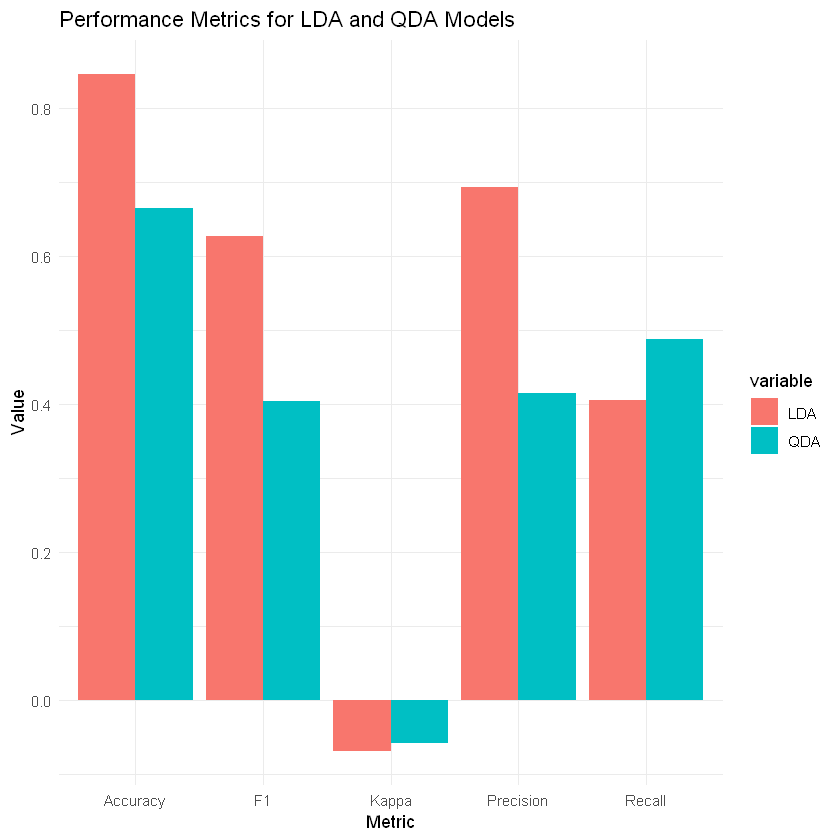

In [96]:
# Determine the best model based on average accuracy
best_model <- ifelse(mean(lda_avg_results["accuracy", ]) > mean(qda_avg_results["accuracy", ]), "LDA", "QDA")

# Train the best LDA model on the entire training data
final_lda_model <- lda(diabetes_012 ~ ., data = train_data)

# Train the best QDA model on the entire training data
final_qda_model <- qda(diabetes_012 ~ ., data = train_data)

# Predict on the test data using both models
lda_predictions <- predict(final_lda_model, test_data)$class
qda_predictions <- predict(final_qda_model, test_data)$class

# Get predicted probabilities for both models
lda_pred_probs <- predict(final_lda_model, test_data)$posterior
qda_pred_probs <- predict(final_qda_model, test_data)$posterior

# Create confusion matrices for both models
lda_confusion <- table(lda_predictions, test_data$diabetes_012)
qda_confusion <- table(qda_predictions, test_data$diabetes_012)

# Calculate metrics for LDA
lda_accuracy <- sum(diag(lda_confusion)) / sum(lda_confusion)
lda_precision <- diag(lda_confusion) / rowSums(lda_confusion)
lda_recall <- diag(lda_confusion) / colSums(lda_confusion)
lda_f1 <- 2 * (lda_precision * lda_recall) / (lda_precision + lda_recall)

# Calculate metrics for QDA
qda_accuracy <- sum(diag(qda_confusion)) / sum(qda_confusion)
qda_precision <- diag(qda_confusion) / rowSums(qda_confusion)
qda_recall <- diag(qda_confusion) / colSums(qda_confusion)
qda_f1 <- 2 * (qda_precision * qda_recall) / (qda_precision + qda_recall)

# Convert confusion matrices to data frames for kappam.fleiss
lda_confusion_df <- as.data.frame(as.table(lda_confusion))
qda_confusion_df <- as.data.frame(as.table(qda_confusion))
lda_kappa <- kappam.fleiss(lda_confusion_df)$value
qda_kappa <- kappam.fleiss(qda_confusion_df)$value

# Create a data frame with the results
results <- data.frame(
    Metric = c("Accuracy", "Precision", "Recall", "F1", "Kappa"),
    LDA = c(lda_accuracy, mean(lda_precision, na.rm = TRUE), mean(lda_recall, na.rm = TRUE), mean(lda_f1, na.rm = TRUE), lda_kappa),
    QDA = c(qda_accuracy, mean(qda_precision, na.rm = TRUE), mean(qda_recall, na.rm = TRUE), mean(qda_f1, na.rm = TRUE), qda_kappa)
)

# Print the results as a table
print(results)

# Plot the metrics
metrics_data <- melt(results, id.vars = "Metric")

ggplot(metrics_data, aes(x = Metric, y = value, fill = variable)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = "Performance Metrics for LDA and QDA Models",
         x = "Metric",
         y = "Value") +
    theme_minimal()

# Return predicted probabilities
probs <- list(lda_pred_probs = lda_pred_probs, qda_pred_probs = qda_pred_probs)

In [88]:
table(lda_predictions)
table(qda_predictions)

lda_predictions
    0     1     2 
47266     0  3470 

qda_predictions
    0     1     2 
29965   950 19821 

In [91]:
plot_confusion_matrix <- function(predictions, actual, title = "Confusion Matrix") {
     # Create a confusion matrix
     confusion <- table(predictions, actual)
     
     # Convert the confusion matrix to a data frame
     confusion_df <- as.data.frame(as.table(confusion))
     
     # Rename the columns to Var1 and Var2
     colnames(confusion_df) <- c("Var1", "Var2", "Freq")
     
     # Plot the confusion matrix with softer colors
     ggplot(confusion_df, aes(Var1, Var2, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black") +
          scale_fill_gradient(low = "lightblue", high = "lightgreen") +
          labs(title = title,
                x = "Predicted",
                y = "Actual") +
          theme_minimal()
}

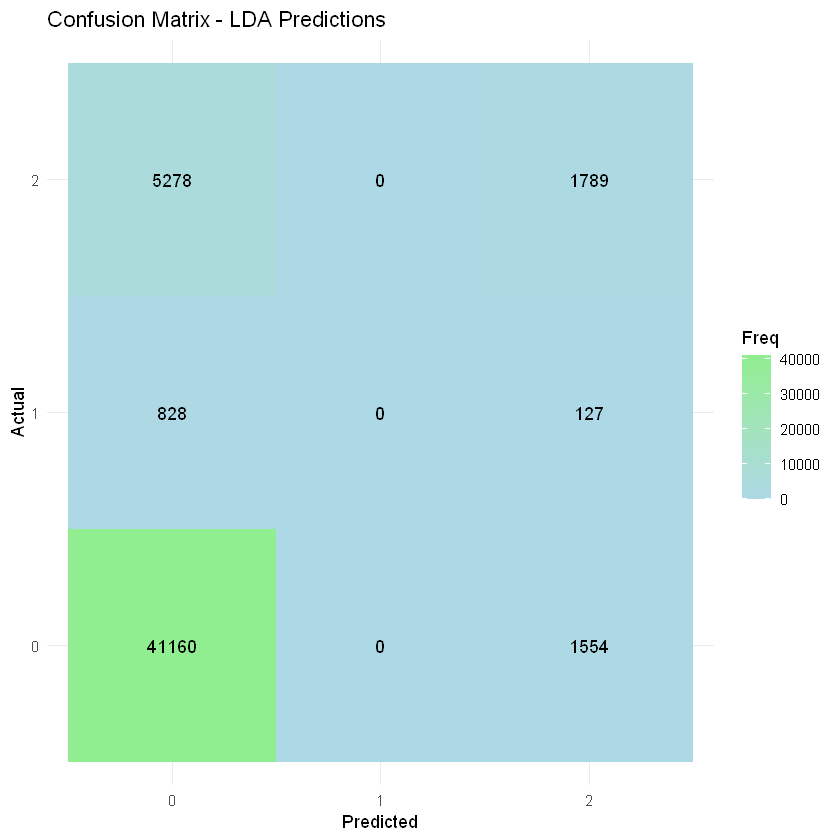

In [92]:
plot_confusion_matrix(lda_predictions, test_data$diabetes_012, "Confusion Matrix - LDA Predictions")

**ĐÁNH GIÁ VỀ SỰ PHÂN LOẠI**

Class 0 (Không bị tiểu đường):

- Được dự đoán là class 0: 41160 (True Negative).
- Sai khi dự đoán thành class 1 hoặc 2: 0 mẫu → Mô hình cực kỳ ưu tiên class này.
- Nhận xét: Mô hình có độ chính xác cao với class 0 nhưng có thể bị overfitting vào class này do mất cân bằng dữ liệu.

---
Class 1 (Tiền tiểu đường):

- Dự đoán đúng là class 1: 127 (True Positive).
- Sai thành class 0: 828 → Rất nhiều lỗi phân loại.
- Sai thành class 2: 0.
- Nhận xét: Mô hình có độ nhạy (Recall) rất thấp đối với class 1. Điều này cho thấy khả năng phát hiện class này của mô hình là rất kém.

---
Class 2 (Bị tiểu đường):

- Dự đoán đúng là class 2: 5278 (True Positive).
- Sai thành class 0: 1789 → Số lỗi phân loại đáng kể.
- Sai thành class 1: 0.
- Nhận xét: Hiệu suất dự đoán của mô hình đối với class 2 là khá tốt nhưng vẫn có tỷ lệ lỗi cao khi nhầm với class 0.

---

**ĐÁNH GIÁ TỔNG QUAN**

1. Sự thiên lệch nghiêm trọng về class (Imbalanced Data):
- Class 0 (Không bị tiểu đường) chiếm số lượng áp đảo.
- Mô hình hoạt động tốt trên class này nhưng lại bỏ qua các class khác (1 và 2).
2. Hiệu suất kém với class nhỏ (1 - Tiền tiểu đường):
- Mô hình gần như không nhận diện được class này, cho thấy cần cải thiện bằng cách xử lý mất cân bằng dữ liệu.
3. Cần cải thiện độ nhạy (Recall) và độ chính xác cân bằng (Balanced Accuracy):
- Tập trung vào cải thiện các chỉ số F1-score và Precision cho các class nhỏ.

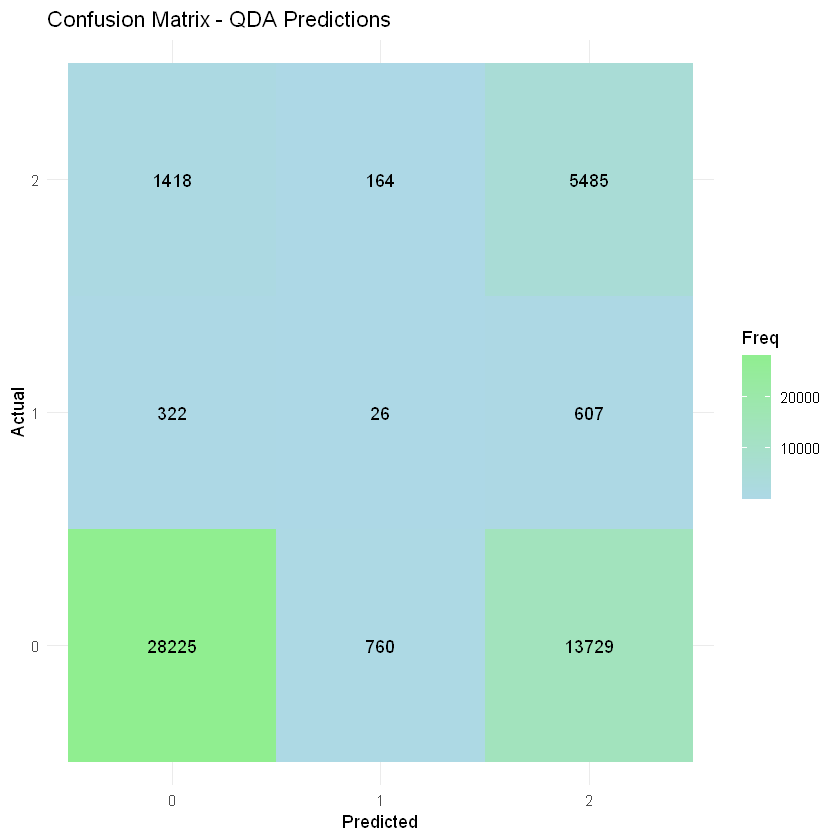

In [93]:
plot_confusion_matrix(qda_predictions, test_data$diabetes_012, "Confusion Matrix - QDA Predictions")

 **ĐÁNH GIÁ VỀ SỰ PHÂN LOẠI**

**Class 0 (Không bị tiểu đường):**
- **Dự đoán đúng là class 0:** 28225 (True Negative).  
- **Sai thành class 1:** 760.  
- **Sai thành class 2:** 13729.  
- **Nhận xét:**  
  - Mô hình có độ chính xác khá cao cho class 0 nhưng vẫn nhầm lẫn một lượng lớn thành class 2 (13729).  
  - Có dấu hiệu mất cân bằng nhưng ít nghiêm trọng hơn so với mô hình LDA trước đó.  

---

**Class 1 (Tiền tiểu đường):**
- **Dự đoán đúng là class 1:** 26 (True Positive).  
- **Sai thành class 0:** 322.  
- **Sai thành class 2:** 607.  
- **Nhận xét:**  
  - Mô hình có hiệu suất cực kỳ thấp với class 1, hầu như không phân loại chính xác.  
  - Recall (Độ nhạy) rất thấp, cho thấy cần cải thiện để nhận diện class này tốt hơn.  

---

**Class 2 (Bị tiểu đường):**
- **Dự đoán đúng là class 2:** 1418 (True Positive).  
- **Sai thành class 0:** 5485.  
- **Sai thành class 1:** 164.  
- **Nhận xét:**  
  - Hiệu suất trên class 2 khá kém với nhiều nhầm lẫn thành class 0.  
  - Độ nhạy thấp nhưng vẫn nhận diện được nhiều mẫu hơn so với class 1.  

---

**ĐÁNH GIÁ TỔNG QUAN**

1. **Sự thiên lệch về class (Imbalanced Data):**  
   - Mô hình tiếp tục cho thấy thiên lệch mạnh về class 0 (Không bị tiểu đường).  
   - Class 1 gần như bị bỏ qua hoàn toàn, cần đặc biệt chú trọng.  

2. **Hiệu suất kém với class nhỏ (1 - Tiền tiểu đường):**  
   - Hiệu suất phân loại cho class 1 là cực kỳ thấp, cần các biện pháp xử lý dữ liệu mất cân bằng và cải thiện thuật toán.  

3. **Cần cải thiện độ nhạy (Recall) và độ chính xác cân bằng (Balanced Accuracy):**  
   - **F1-score** và **Precision-Recall Curve** cần được theo dõi sát sao thay vì chỉ dựa vào accuracy tổng thể.  


### Thử trên Data Oversampling

In [ ]:
oversampling_data <- read.csv("../data/oversampled_data.csv")


### Thử trên Data Undersampling

### Thử trên Data SMOTE Sampling

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] 0.01406718


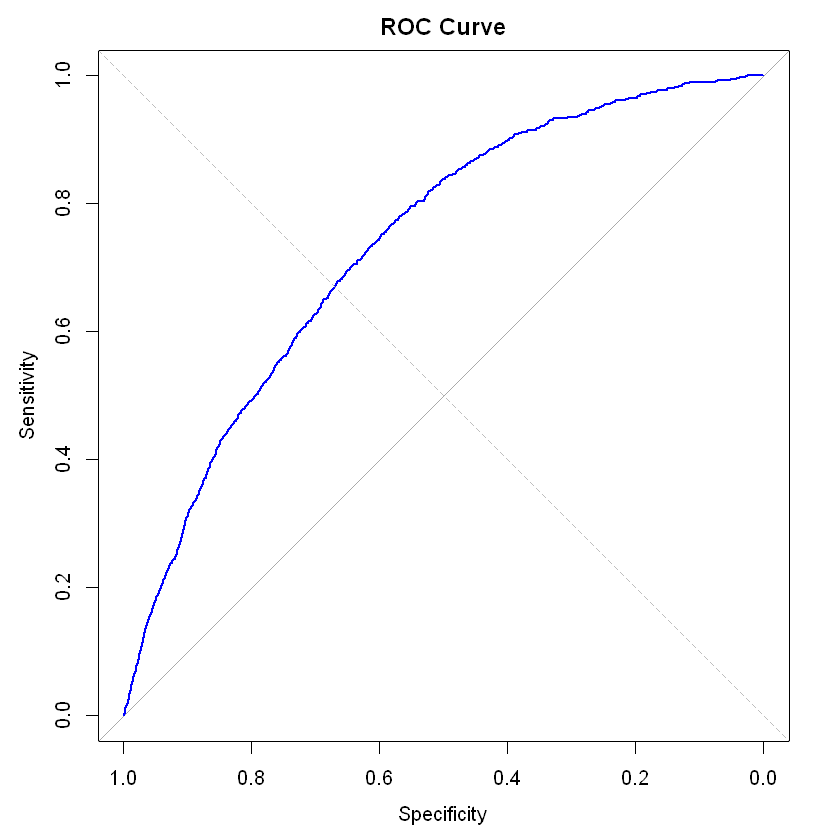

In [102]:
# Ensure the necessary packages are installed
if (!requireNamespace("pROC", quietly = TRUE)) {
	install.packages("pROC")
}
if (!requireNamespace("PRROC", quietly = TRUE)) {
	install.packages("PRROC")
}

library(pROC)
library(PRROC)

# Tính toán ROC Curve
roc_curve <- roc(test_data$diabetes_012, as.numeric(probs$lda_pred_probs[, 2]), levels = c("0", "1"), direction = "<")

# Vẽ ROC Curve
plot(roc_curve, col = "blue", main = "ROC Curve")
abline(a = 0, b = 1, col = "gray", lty = 2)  # Đường chéo tham chiếu

# Xác định ngưỡng tối ưu
optimal_idx <- which.max(roc_curve$sensitivities + roc_curve$specificities)
roc_optimal_threshold <- roc_curve$thresholds[optimal_idx]

print(roc_optimal_threshold)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] 0.04444361


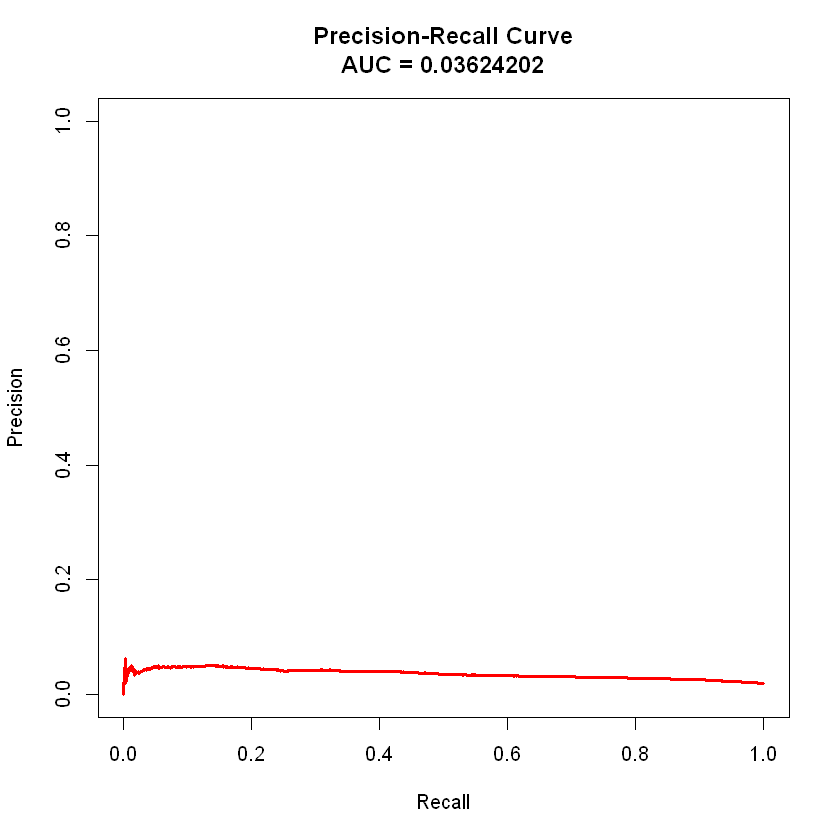

In [101]:
# Đảm bảo cài đặt các gói cần thiết
if (!requireNamespace("PRROC", quietly = TRUE)) {
  install.packages("PRROC")
}
if (!requireNamespace("pROC", quietly = TRUE)) {
  install.packages("pROC")
}

# Nạp thư viện
library(PRROC)
library(pROC)

# Tính toán Precision-Recall Curve
pr <- pr.curve(scores.class0 = as.numeric(probs$lda_pred_probs[, 2]),
               weights.class0 = as.numeric(test_data$diabetes_012 == "1"),
               curve = TRUE)

# Vẽ Precision-Recall Curve
plot(pr, col = "red", main = "Precision-Recall Curve")

# Tính F1-Score tại từng ngưỡng
precision <- pr$curve[, 1]  # Precision
recall <- pr$curve[, 2]     # Recall

# Tính F1-score
f1_scores <- 2 * (precision * recall) / (precision + recall)

# Xác định ngưỡng tối ưu
optimal_idx <- which.max(f1_scores)  # Vị trí F1-score lớn nhất
f1_optimal_threshold <- pr$curve[optimal_idx, 3]  # Ngưỡng tương ứng

# In ra ngưỡng tối ưu
print(f1_optimal_threshold)


In [105]:
# Áp dụng ngưỡng mới
predicted_class <- ifelse(probs$lda_pred_probs[, 2] > f1_optimal_threshold, 1, 0)

# Tính Confusion Matrix
conf_matrix <- table(Predicted = predicted_class, actual = test_data$diabetes_012)
print(conf_matrix)

# Tính độ đo hiệu suất
library(caret)
confusionMatrix(as.factor(predicted_class), as.factor(test_data$diabetes_012))

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

         actual
Predicted     0     1     2
        0 41014   807  5958
        1  1700   148  1109


Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(as.factor(predicted_class), as.factor(test_data$diabetes_012)):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction     0     1     2
         0 41014   807  5958
         1  1700   148  1109
         2     0     0     0

Overall Statistics
                                          
               Accuracy : 0.8113          
                 95% CI : (0.8079, 0.8147)
    No Information Rate : 0.8419          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0843          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9602 0.154974   0.0000
Specificity            0.1567 0.943573   1.0000
Pos Pred Value         0.8584 0.050051      NaN
Neg Pred Value         0.4251 0.983110   0.8607
Prevalence             0.8419 0.018823   0.1393
Detection Rate         0.8084 0.002917   0.0000
Detection Prevalence   0.9417 0.058282   0.0000
Balanced Accuracy